In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
import scipy.io

import sys
sys.path.append("..")
sys.path.append("../..")
from util import *
from model.fls import FLS

In [2]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:1'

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [3]:
# get data
filename = '1D_Burgers_Sols_Nu0.001.hdf5'
root_path = '/home/data2/PDEData/1D/Burgers/Train/'
data = PINNDataset1Dpde(filename, root_path=root_path, val_batch_idx=-1)

X_inn = data.data_input
choice = np.random.choice(np.arange(0, X_inn.shape[0]), 25600, replace=False)
X_inn = X_inn[choice, :]

X_init, U_init = data.get_initial_condition()
X_bdL, U_bdL, X_bdR, U_bdR = data.get_boundary_condition()

X_inn  = X_inn.requires_grad_(True).to(device)  # 内部点坐标(x,t)
X_init = X_init.requires_grad_(True).to(device)  # 初始点坐标(x,t)
X_bdL  = X_bdL.requires_grad_(True).to(device)  # 边界点坐标(x,t)
X_bdR  = X_bdR.requires_grad_(True).to(device)
U_bdL  = U_bdL.to(device)
U_bdR  = U_bdR.to(device)
U_init = U_init.to(device)

# 分别提取散点的x t坐标 --> 列表
x_res, t_res = X_inn[:,0:1], X_inn[:,1:2]
x_left, t_left = X_bdL[:,0:1], X_bdL[:,1:2]
x_right, t_right = X_bdR[:,0:1], X_bdR[:,1:2]
x_init, t_init = X_init[:,0:1], X_init[:,1:2]


print('res shape: ', X_inn.shape, 'X_init shape: ', X_init.shape, 'X_bdL shape: ', X_bdL.shape, 'X_bdR shape: ', X_bdR.shape)
print('U_bdL shape: ', U_bdL.shape, 'U_bdR shape: ', U_bdR.shape, 'U_init shape: ', U_init.shape)

['t-coordinate', 'tensor', 'x-coordinate']
res shape:  torch.Size([25600, 2]) X_init shape:  torch.Size([1024, 2]) X_bdL shape:  torch.Size([201, 2]) X_bdR shape:  torch.Size([201, 2])
U_bdL shape:  torch.Size([201, 1]) U_bdR shape:  torch.Size([201, 1]) U_init shape:  torch.Size([1024, 1])


In [4]:
# ## get data

# res, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 101, 101)
# res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)

# res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
# b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
# b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
# b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
# b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

# x_res, t_res = res[:,0:1], res[:,1:2]
# x_left, t_left = b_left[:,0:1], b_left[:,1:2]
# x_right, t_right = b_right[:,0:1], b_right[:,1:2]
# x_upper, t_upper = b_upper[:,0:1], b_upper[:,1:2]
# x_lower, t_lower = b_lower[:,0:1], b_lower[:,1:2]

# def init_weights(m):
#     if isinstance(m, nn.Linear):
#         torch.nn.init.xavier_uniform(m.weight)
#         m.bias.data.fill_(0.01)

In [5]:
# Train FLS 
model = FLS(in_dim=2, hidden_dim=512, out_dim=1, num_layer=4).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')

print(model)
print(get_n_params(model))

/tmp/ipykernel_25547/1660943584.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


FLS(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): SinAct()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)
527361


In [6]:
loss_track = []

for i in tqdm(range(500)):
    def closure():
        # 预测值
        pred_res = model(x_res, t_res)  # (n, 1)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        pred_init = model(x_init, t_init)

        # loss
        u = pred_res
        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]  # (n, 1)
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        # print('u_x: ', u_x.shape)

        loss_res = torch.mean((u_t + u * u_x) ** 2)
        loss_bc = torch.mean((pred_left - U_bdL) ** 2 + (pred_right - U_bdR) ** 2)  
        loss_ic = torch.mean((pred_init[:,0] - U_init) ** 2)
        # print('loss: ', loss_res.shape)
        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss = loss_res + loss_bc + loss_ic
        optim.zero_grad()
        loss.backward()
        return loss

    optim.step(closure)
    # if i % 10 == 0:
    #     tqdm.write('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
    

100%|██████████| 500/500 [11:21<00:00,  1.36s/it]


In [7]:
# ## train

# loss_track = []

# for i in tqdm(range(500)):
#     def closure():
#         pred_res = model(x_res, t_res)
#         pred_left = model(x_left, t_left)
#         pred_right = model(x_right, t_right)
#         pred_upper = model(x_upper, t_upper)
#         pred_lower = model(x_lower, t_lower)

#         u = pred_res
#         u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
#         u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

#         loss_res = torch.mean((u_t + u * u_x) ** 2)
#         loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
#         loss_ic = torch.mean((pred_left[:,0] - torch.sin(x_left[:,0])) ** 2)

#         loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

#         loss = loss_res + loss_bc + loss_ic
#         optim.zero_grad()
#         loss.backward()
#         return loss

#     optim.step(closure)

In [8]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

Loss Res: 0.001846, Loss_BC: 0.000900, Loss_IC: 0.039559
Train Loss: 0.042305


relative L1 error: 0.694773
relative L2 error: 0.553925


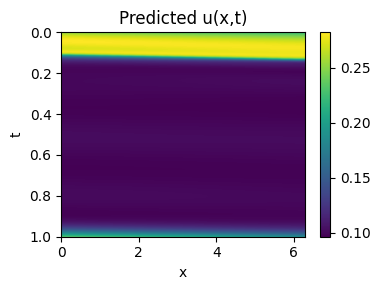

In [9]:
# Visualize PINNs 
# [-1, 1] 1024个位置，[1.81, 2.00] 20个时刻, [20480, 2] 个离散点
test_input, test_gt = data.get_test_data(n_last_time_steps=20, n_components=1)
x_test, t_test = test_input[:,0:1].to(device), test_input[:,1:2].to(device)

with torch.no_grad():
    test_pred = model(x_test, t_test)

# prepare data for metrics eval
test_pred = data.unravel_tensor(test_pred, n_last_time_steps=20, n_components=1)  # [1, 1024, 20, 1]
test_gt = data.unravel_tensor(test_gt, n_last_time_steps=20, n_components=1)

test_pred = test_pred[0, :, :, 0].detach().cpu() .numpy() # (1, n_x, n_last_time_steps, n_components) --> (n_x, n_last_time_steps)
test_gt = test_gt[0, :, :, 0].detach().cpu().numpy()

rl1 = np.sum(np.abs(test_gt-test_pred)) / np.sum(np.abs(test_gt))
rl2 = np.sqrt(np.sum((test_gt-test_pred)**2) / np.sum(test_gt**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(4,3))
plt.imshow(test_pred, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./burgers_pinns_pred.png')
plt.show()

In [10]:
# # Visualize FLS 
# res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
# x_test, t_test = res_test[:,0:1], res_test[:,1:2]

# with torch.no_grad():
#     pred = model(x_test, t_test)[:,0:1]
#     pred = pred.cpu().detach().numpy()

# pred = pred.reshape(101,101)

# mat = scipy.io.loadmat('./burgers.mat')
# u = mat['u'].reshape(101,101)

# rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
# rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

# print('relative L1 error: {:4f}'.format(rl1))
# print('relative L2 error: {:4f}'.format(rl2))

# plt.figure(figsize=(4,3))
# plt.imshow(pred, extent=[0,np.pi*2,1,0], aspect='auto')
# plt.xlabel('x')
# plt.ylabel('t')
# plt.title('Predicted u(x,t)')
# plt.colorbar()
# plt.tight_layout()
# plt.savefig('./image/burgers_fls_pred.png')
# plt.show()

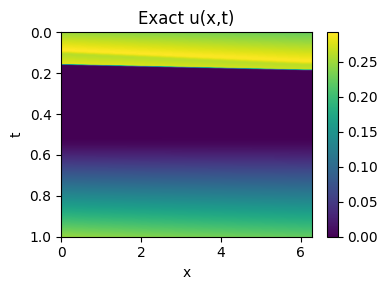

In [11]:
plt.figure(figsize=(4,3))
plt.imshow(test_gt, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/burgers_exact.png')
plt.show()

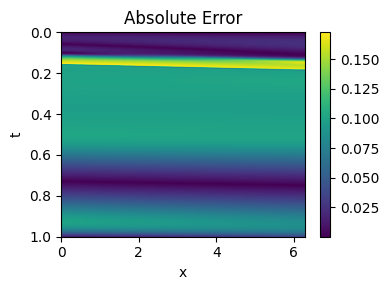

In [12]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(test_pred - test_gt), extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/burgers_fls_error.png')
plt.show()